In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
####
#
# Dataset paths
#
####

training_dir='./nih-malaria/cell_images/train/'
validation_dir='./nih-malaria/cell_images/val/'
test_dir='./nih-malaria/cell_images/test/'

In [87]:
####
#
# Img augmentation to avoid overfitting:
# resacle the image into a 1-0 range,
# rotate the image left or right up to 180 degrees,
# flip the image randomly horizontaly and/or veritacly
#
####

train_datagen = ImageDataGenerator(
 rescale=1/255,
 rotation_range=180,
 horizontal_flip=True,
 vertical_flip = True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

#specify that this will generate images for the raining process by flowing from a dir.
#target = to image size
#mode is binary because there are two types of img
#use categorical if there are more

###
#
# Specifying that during training images will be flown from a directory and augmented in real time
# Resize images into 100x100
# class_mode = 'binary' determines label arrays returned, because there are 2 classes binary mode is used
#
###
train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(100,100),
        class_mode='binary'
    )

validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(100,100),
    class_mode='binary'
    )

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    class_mode='binary',
    shuffle=False
    )

Found 22046 images belonging to 2 classes.
Found 2754 images belonging to 2 classes.
Found 2758 images belonging to 2 classes.


In [64]:
####
#
# Checking labels of classes
#
####
print(test_generator.class_indices)
print(test_generator.labels[1500])
print(test_generator.labels[1500])


{'parasitized': 0, 'uninfected': 1}
1
1
[0 0 0 ... 1 1 1]


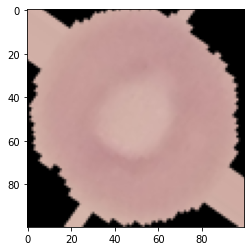

In [39]:
####
#
# Aprooving that images are loaded
#
####

x,y = train_generator.next()
image=x[0]
plt.imshow(image)
plt.show()
    

In [40]:
####
#
# Model architecture
# The model consists of an input layer, hidden layers and output layer.
# Frist layer is the input layer with 64 nodes, activation function ReLU, input shape is specified as 100x100 with 3 channels,
# padding is set to same meaning where needed the image sides will be padded with zeroes.
# Following layers are hidden layers with different parameters.
#
# Conv2D is a convolutional layer that learns a set of kernels with different parameters.
# MaxPooling2D picks max values from a 2x2 pool.
# Flatten layer converts image into a 1-D array
# Dense layer is a fully connected neuron layer
# The output layer has 1 neuron because we want 1 prediction for an image.
#
####

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(100,100,3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2),padding="same" ),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Flatten(input_shape=(100,100,)),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
                           ])

In [41]:
####
#
# The summary of the model explaining how many parameters are learned
# The first layer will learn 1792 parameters it's calculated ((3*3(kernel pixel sizes)) * 64(neurons) * 3(channels)) + 64.
# The second layer, MaxPooling does not learn anything it only picks the max values from the pool so the image size is reduced. 
# other layers follow the same principle. Dropout layers only block a percentage of neurons to reduce overfitting.
# Flatten layer flatens the image 4*4*512 which is the new shape.
#
####

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)      

In [42]:
####
#
# Compiling the network.
# I specify the loss function used, the optimizer and specifying to get accuracy results after each epoch
#
###

model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=0.03),
              metrics=['accuracy'])

In [43]:
####
#
# Training the model
# I specify the training data, epochs and validation data used to compare how the model is doing with unseen data
#
####

hisotry = model.fit(
    train_generator,
    epochs=30,
    validation_data = validation_generator)

Epoch 1/30
689/689 [==============================] - 57s 81ms/step - loss: 0.6721 - accuracy: 0.5760 - val_loss: 0.7312 - val_accuracy: 0.5142
Epoch 2/30
689/689 [==============================] - 53s 77ms/step - loss: 0.2930 - accuracy: 0.8903 - val_loss: 0.1506 - val_accuracy: 0.9546
Epoch 3/30
689/689 [==============================] - 54s 78ms/step - loss: 0.1604 - accuracy: 0.9521 - val_loss: 0.1438 - val_accuracy: 0.9542
Epoch 4/30
689/689 [==============================] - 54s 79ms/step - loss: 0.1512 - accuracy: 0.9550 - val_loss: 0.1411 - val_accuracy: 0.9535
Epoch 5/30
689/689 [==============================] - 58s 84ms/step - loss: 0.1459 - accuracy: 0.9569 - val_loss: 0.1349 - val_accuracy: 0.9532
Epoch 6/30
689/689 [==============================] - 62s 90ms/step - loss: 0.1426 - accuracy: 0.9575 - val_loss: 0.1337 - val_accuracy: 0.9539
Epoch 7/30
689/689 [==============================] - 57s 82ms/step - loss: 0.1417 - accuracy: 0.9577 - val_loss: 0.1451 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


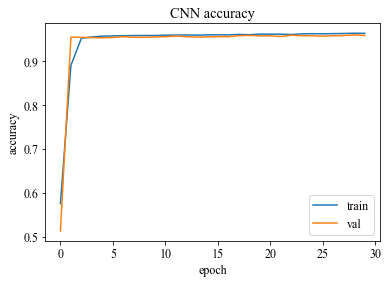

In [93]:
####
#
# Summarizing the history of accuracy
#
####

import matplotlib.pyplot as plt

print(hisotry.history.keys())
plt.plot(hisotry.history['accuracy'])
plt.plot(hisotry.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

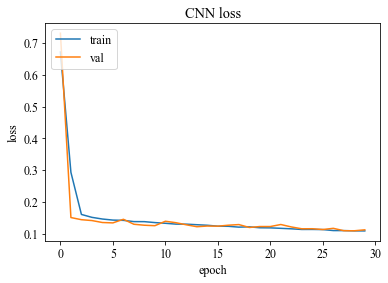

In [94]:
####
#
# Summarizing the history of loss values
#
####

plt.plot(hisotry.history['loss'])
plt.plot(hisotry.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [125]:
####
#
# Evaluating the model with test set. The result shows the percentage of how well the model was able to classify
# images by the given dataset
#
####

accuracy_score = model.evaluate(test_generator)

87/87 [==============================] - 4s 42ms/step - loss: 0.1130 - accuracy: 0.9590


In [100]:
####
#
# Printing a confusion matrix and a classification report giving f1-score,precision,recall
#
####

predictions = model.predict_classes(test_generator)
y_pred = np.rint(predictions)
y_true = test_generator.classes

cm = metrics.confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

print(metrics.classification_report(y_true, y_pred))

F:\anacnoda_n\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix:
[[1299   80]
 [  33 1346]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1379
           1       0.94      0.98      0.96      1379

    accuracy                           0.96      2758
   macro avg       0.96      0.96      0.96      2758
weighted avg       0.96      0.96      0.96      2758



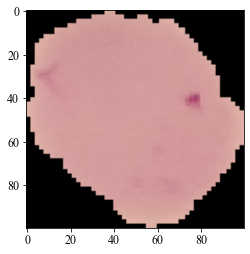

{'parasitized': 0, 'uninfected': 1}
prediction:  [0] actual:  1.0
parasitized


In [122]:
####
#
# Using the model to predict a given image
# The images tested are taken from the validation dataset as an example to show how the model might be used.
#
####

####
#
# Get a random image from the validation set and show it.
# Convert image into a 2D array, expand_dims converts the image into 3D as the
# model requires this. vstack stacks the 3d array vertically so it's in the same
# shape as the training data.
####

x,y = validation_generator.next()
image=x[0]
plt.imshow(image)
plt.show()

image = np.array(image)
image = np.expand_dims(image,axis=0)
image = np.vstack([image])


####
#
# Perform classification on the provided image. Get an array of classifications.
#
####

classes = model.predict_classes(image)
    
####
#
# Print the labels of classes.
# Print the predicted label and the actual label
# Print out the predicted class verbaly
#
####
    
print(validation_generator.class_indices)
print("prediction: ",classes[0],"actual: ",y[0])

if classes[0]>0.5:
    print(" uninefected")
else:
    print("parasitized")
    
    
    


In [92]:
####
#
# Saving the trained model so it is reusable later.
#
####

model.save('./saved_models/CNNmodel.h5')

In [35]:
####
#
# Load the trained model from the saved files so it's reusable
#
####

savedModel = tf.keras.models.load_model('./saved_models/CNNmodel.h5')
savedModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)      

In [99]:
####
#
# Printing a confusion matrix and a classification report giving f1-score,precision,recall
#
####

predictions = savedModel.predict_classes(test_generator)
y_pred = np.rint(predictions)
y_true = test_generator.classes

cm = metrics.confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

print(metrics.classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1379
           1       0.94      0.98      0.96      1379

    accuracy                           0.96      2758
   macro avg       0.96      0.96      0.96      2758
weighted avg       0.96      0.96      0.96      2758

